In [1]:
import numpy as np

In [2]:
# todo: implement with cython
class e_divisive:
    def __init__(self, verbose = False):
        self.verbose = verbose
        
    def divisive(self,Z, k =None, p0=.05, m = 30, R=199, alpha=1):
        self.Z = Z
        self.p0 = p0
        self.min_size = m
        self.R = R
        self.alpha = alpha
        self.D = self.create_distance_matrix(Z)
        self.length = len(Z)
        self.energy = np.zeros((self.length,2))
        if k is None:
            self.k = self.length
        else:
            self.R = 0
        ret = pvals = permutations = None
        changes = [0,self.length]
        k_hat = 1 
        con = None
        while self.k > 0:
            if self.verbose:
                print("\r at least {}% completed".format((self.length - self.k+1)/self.length)*100,
                     end='')
            tmp = self.split(changes, self.D, self.min_size, False, self.energy)
            i = int(tmp[0])
            j = int(tmp[1])
            new_changes = tmp[2]
            estat = tmp[3]
            con = new_changes[-1]
            if con == -1:
                break
            result = self.sig_test(self.D, self.R, changes, self.min_size, estat,
                                  self.energy)
            pval = result[0]
            permutations = [permutations, result[1]]
            pvals = [pvals, pval]
            if pval > self.p0:
                break
            changes = new_changes
            k_hat += 1
            self.k -= 1
        tmp = sorted(changes)
        return tmp
            
    def create_distance_matrix(self, Z):
        length = len(Z)
        matrix = np.zeros((length, length))
        for i in range(length):
            for j in range(length):
                matrix[i][j] = np.abs(Z[i] - Z[j])**self.alpha
        return matrix   

    def sig_test(self, D, R, changes, min_size, estat, energy):
        if R == 0:
            return 0
        over = 0
        for i in range(R):
            D1 = self.perm_cluster(D, changes)
            tmp = self.split(changes = changes, D =D1, min_size = min_size, \
                             for_sim = True, energy=energy)
            if tmp[3]>=estat:
                over += 1
        p_val = (1+over)/(R+1) # todo: might be problematic and -1
        return [p_val, R]
    
    def perm_cluster(self, D, changes):
        D1 = D.copy()
        changes1 = changes.copy()
        changes1 = sorted(changes1)
        K = len(changes1) - 1
        for i in range(K):
            u = np.arange(changes1[i],changes1[i+1])
            np.random.shuffle(u)
            self.u = u
            mesh = np.meshgrid(u,u,indexing='ij')
            D1[changes1[i]:changes1[i+1],changes1[i]:changes1[i+1]]=D1[mesh[0],mesh[1]]
        return D1
            
    def split_pointC(self, start, end, D, min_size):
        s = start
        best = [-1, -np.inf]
        num_points = end - start + 1
        tau = min_size
        keppa = min_size << 1
        cut1 = D[s:tau,s:tau] # notice the difference with Rc++
        cut2 = D[tau:keppa,tau:keppa]
        cut3 = D[s:tau,tau:keppa]
        A = np.sum(cut1)/2
        B1 = np.sum(cut2)/2
        AB1 = np.sum(cut3)
        tmp = 2*AB1/((keppa-tau)*tau) - 2*B1/((keppa-tau-1)*(keppa-tau)) - \
                                            2*A/((tau-1)*tau)
        tmp *= (tau*(keppa-1)/keppa)
        if tmp > best[1]:
            best[0]=tau+start
            best[1] = tmp
        keppa += 1

        B = np.ones(num_points+1)*B1 # memorization, 
        AB = np.ones(num_points+1)*AB1
        for i in range(keppa, num_points):
            B[i] = B[i-1]+np.sum(D[i,tau:i-1])# mind the interval
            AB[i] = AB[i-1]+np.sum(D[i,0:tau])
            tmp = 2*AB[i]/((i-tau)*tau) - 2*B[i]/((i-tau-1)*(i-tau))-2*A/(tau*(tau-1))
            tmp *= (tau*(i-tau)/i)
            if tmp > best[1]:
                best[0] = tau + start
                best[1] = tmp
        tau += 1

        for i in range(tau,end):
            keppa = i + min_size
            if keppa > num_points:
                break
            addA = np.sum(D[i-1,0:i-1])
            A+=addA
            addB = np.sum(D[i-1,i:keppa-1])
            for j in range(keppa,num_points):
                addB += D[i-1,j-1]
                B[j]-=addB
                AB[j]+=(addB -addA)
                tmp = 2*AB[j]/((j-i)*i)-2*B[j]/((j-i-1)*(j-i))-2*A/((i-1)*i)
                tmp *= (i*(j-i)/j)
                if tmp > best[1]:
                    best[0] = i+start
                    best[1] = tmp
        return best

    def splitPoint(self, start, end, D, min_size):
        if end - start + 1<2*min_size:
            return [-1, -np.inf]
        D1 = D[start:end+1, start:end+1]
        return self.split_pointC(start=start, end=end, D=D1, min_size=min_size)

    def split(self, changes, D, min_size, for_sim, energy):
        changes1 = changes.copy()
        splits = sorted(changes1)
        best = [-1,-np.inf]
        ii = jj = -1
        if for_sim:
            for i in range(1,len(splits)):
                tmp = self.splitPoint(splits[i-1],splits[i]-1,D,min_size)
                if tmp[1]>best[1]:
                    ii = splits[i-1]
                    jj = splits[i]-1
                    best = tmp
            new_changes = changes1.copy()
            new_changes.append(int(best[0]))
            return [ii,jj,new_changes,best[1]]
        else:
            for i in range(1, len(splits)):
                if energy[int(splits[i-1]),0] != 0:
                    tmp = energy[splits[i-1],]
                else:
                    tmp = self.splitPoint(splits[i-1],splits[i]-1,D,min_size)
                    energy[int(splits[i-1]),0] = tmp[0]
                    energy[int(splits[i-1]),1] = tmp[1]
                if tmp[1]>best[1]:
                    ii = splits[i-1]
                    jj = splits[i]-1
                    best = tmp
        new_changes = changes1.copy()
        new_changes.append(int(best[0]))
        energy[ii,0] = 0
        energy[jj,1] = 0
        return [ii,jj,new_changes,best[1]]

In [3]:
import pandas as pd

In [4]:
file = pd.read_csv('/Users/jingang/Desktop/SPY.csv')

In [5]:
file.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-10-11,116.720001,116.970001,116.250000,116.650002,97.348389,103098300
1,2010-10-12,116.269997,117.349998,115.650002,117.010002,97.648834,182210000
2,2010-10-13,117.660004,118.550003,117.379997,117.919998,98.408249,194347200
3,2010-10-14,117.809998,118.010002,116.720001,117.459999,98.024368,217764300
4,2010-10-15,118.279999,118.349998,116.760002,117.699997,98.224648,243705000


In [6]:
close = file['Close']
date = file['Date']

In [7]:
import matplotlib.pyplot as plt
% matplotlib inline

In [8]:
val = np.array(close)

In [9]:
ed = e_divisive()
tmp = ed.divisive(Z=val[:500],p0=.05,m=30)

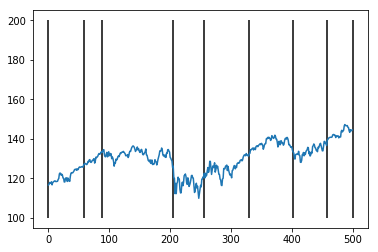

NameError: name 'ret' is not defined

In [10]:
plt.plot(val[:500])
plt.vlines(tmp,ymin=100,ymax=200)
plt.show()
plt.plot(ret[:500])
plt.vlines(tmp,ymin=-0.1,ymax=.1)

In [ ]:
tmp